# Multivariate time series forecasting with sktime

Time series forecasting plays a critical role in domains like finance, energy, healthcare, and supply chain management—where understanding how things evolve over time is essential. In particular, multivariate time series forecasting allows us to model the interactions between multiple variables as they change over time. This is helpful when performing estimations with [exogenous](https://www.sktime.net/en/stable/glossary.html#term-Exogenous) variables (like weather) that may influence a target variable (like energy demand). In this context, weather is an independent variable which may have an impact on our target variable. In contrast, energy demand represents an [endogenous](https://www.sktime.net/en/stable/glossary.html#term-Endogenous) variable, dependent on it's own earlier values in the time series and potentially other external variables like the weather.

This tutorial focuses on using the sktime library—a unified framework for machine learning with time series data. Sktime aims to simplify the workflow for time series problems by providing consistent, composable tools for tasks like forecasting, classification, and transformation. Its design is inspired by the scikit-learn API, making it approachable for those familiar with Python's broader ML ecosystem. Sktime also allows users to create pipelines tailored to time series data by combining dedicated transformers and classifiers. Forecasting pipelines allow for the sequential application of preprocessing steps and forecasting models, facilitating a streamlined workflow for time series forecasting tasks. While this tutorial solely focuses on comparing univariate and multivariate forecasting models, it's worth noting that sktime also supports hierarchical forecasting, enabling the application of different forecasting models at various levels of data aggregation and fine tuning by the use of hyperparameters. Sktime allows for time series classification, regression, and clustering while enabling users to switch between models without changing how one prepares or runs the code. This makes it much easier to experiment and build better models faster. 

#### Univariate vs. Multivariate Time Series

In a univariate time series, we track a single variable over time (e.g., daily temperature). In contrast, a multivariate time series involves multiple interdependent variables tracked over the same time interval (e.g., temperature, humidity, and energy consumption recorded hourly). Multivariate modeling can help capture the underlying dynamics between these variables, leading to more accurate forecasts.

#### Forecasting Energy Demand

To demonstrate multivariate forecasting with sktime, we’ll use the Hourly Energy Demand Dataset. This dataset contains four years of hourly electricity consumption and generation data in Spain (2015–2018). Because energy demand is influenced by many factors—such as weather conditions and time of day—this dataset provides an ideal foundation for multivariate modeling.

## Step 1. Setup your environment

While you can choose from several tools, this tutorial walks you through how to set up an IBM account to use a Jupyter Notebook.

1. Log in to [watsonx.ai](https://dataplatform.cloud.ibm.com/registration/stepone?context=wx&apps=all) by using your IBM Cloud® account.

2. Create a [watsonx.ai project](https://www.ibm.com/docs/en/watsonx/saas?topic=projects-creating-project).

3. Create a [Jupyter Notebook](https://www.ibm.com/docs/en/watsonx/saas?topic=editor-creating-managing-notebooks).

This step opens a Jupyter Notebook environment where you can copy the code from this tutorial. Alternatively, you can download this notebook to your local system and upload it to your watsonx.ai project as an asset. This Jupyter Notebook can be found on [GitHub](https://github.com/IBM/ibmdotcom-tutorials).

## Step 2. Install and import relevant libraries

We need a few libraries and modules for this tutorial. Make sure to import the following ones and if they're not installed, you can use pip or another package manager to install them.

We'll be using `os` and `wget` to retrieve the data file and `pandas` to load the dataset. In order to visualize the aggregate data series, we'll be using the `plot_series` function from `sktime.utils.plotting` which utilizes functionality from `seaborn`. To split the data into training and test sets for our experiment, we'll use the `temporal_train_test_split` function from `sktime.split`. Before modeling, we'll use the `StationarityADF` function from `sktime.param_est.stationarity` to test the time series for stationarity and the `Differencer` function from `sktime.transformations.series.differencer` to transform the time series. While preparing the data, we'll use `grangercausalitytests` from `statsmodels.tsa.stattools` to evaluate whether the exogenous variables in our tabular dataset are predictive of the target variable.

For time series forecasting, we'll use the `NaiveForecaster` for univariate forecasting. For multivariate forecasting, we'll use the `VAR` model as the regressor. `Sktime` does allow for Prophet, SARIMAX, ARIMA (using the `pmdarima` library) and some additional non-native deep learning model selection, but for the purpose of this tutorial the `VAR` model will be used. To evaluate the performance of the model, we'll use the `mean_absolute_percentage_error` (MAPE) metric from `sklearn.performance_metrics.forecasting`. 

In [1]:
%pip install scikit-learn sktime seaborn statsmodels wget -q

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import wget
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.colors import ListedColormap

from sktime.split import temporal_train_test_split
from sktime.param_est.stationarity import StationarityADF
from sktime.transformations.series.difference import Differencer
from statsmodels.tsa.stattools import grangercausalitytests
from sktime.utils.plotting import plot_series
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.var import VAR
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error

## Step 3. Load and prepare the dataset

As described earlier, this tutorial uses the [Hourly energy demand dataset](https://github.com/IBM/watson-machine-learning-samples/raw/refs/heads/master/cloud/data/energy/energy_dataset.csv) containing 4 years of electrical consumption and energy generation data gathered in Spain from 2015 to 2018 aggregated by hour. It is a modified version of the [Hourly energy demand generation and weather dataset](https://www.kaggle.com/datasets/nicholasjhana/energy-consumption-generation-prices-and-weather/data). You can find more details about the dataset, including metadata in the preceding links. You can also use this tutorial as a template to explore other well known datasets with `sktime` (i.e. The classic Box & Jenkins airline data from `sktime.datasets import load_airline` ). 

For simplicity, the tabular dataset was prepared to have no missing values and to remove irrelevant columns.

In [3]:
filename = 'energy_dataset.csv'
base_url = 'https://github.com/IBM/watson-machine-learning-samples/raw/refs/heads/master/cloud/data/energy/'

if not os.path.isfile(filename): wget.download(base_url + filename)

Let's examine the first few rows of the dataset. We can see the time column showing a timestamp for each hour. Other columns show numeric data types for energy generation from different sources, weather forecast details and actual energy usage, termed as `total load actual`. This will be our target column, the column for which we are trying to predict values. 

In a univariate forecasting scenario, we'll use only the `total load actual` column to forecast future values of that variable. To perform multivariate forecasting, we'll use additional columns as input to our model to help inform it's predictions for `total load actual`. These additional columns provide details about energy generation and weather forecasts for each hour, enhancing the ability to predict actual energy demand on an hourly basis.

In [4]:
df = pd.read_csv(filename)
df.head()

,time,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind onshore,forecast solar day ahead,forecast wind onshore day ahead,total load forecast,total load actual
0,2015-01-01 00:00:00,447.0,329.0,4844.0,4821.0,162.0,863.0,1051.0,1899.0,7096.0,43.0,73.0,49.0,196.0,6378.0,17.0,6436.0,26118.0,25385.0
1,2015-01-01 01:00:00,449.0,328.0,5196.0,4755.0,158.0,920.0,1009.0,1658.0,7096.0,43.0,71.0,50.0,195.0,5890.0,16.0,5856.0,24934.0,24382.0
2,2015-01-01 02:00:00,448.0,323.0,4857.0,4581.0,157.0,1164.0,973.0,1371.0,7099.0,43.0,73.0,50.0,196.0,5461.0,8.0,5454.0,23515.0,22734.0
3,2015-01-01 03:00:00,438.0,254.0,4314.0,4131.0,160.0,1503.0,949.0,779.0,7098.0,43.0,75.0,50.0,191.0,5238.0,2.0,5151.0,22642.0,21286.0
4,2015-01-01 04:00:00,428.0,187.0,4130.0,3840.0,156.0,1826.0,953.0,720.0,7097.0,43.0,74.0,42.0,189.0,4935.0,9.0,4861.0,21785.0,20264.0


In order to use `sktime` for forecasting, we need to set the time index of our `pandas DataFrame` to be of type `PeriodIndex`. We'll also specify the frequency of the index as `"h"` for hourly. 

In [5]:
df.set_index(pd.PeriodIndex(df['time'], freq='h'),inplace=True)
df.drop(['time'], axis=1, inplace=True)
df.head()

,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind onshore,forecast solar day ahead,forecast wind onshore day ahead,total load forecast,total load actual
time,,,,,,,,,,,,,,,,,,
2015-01-01 00:00,447.0,329.0,4844.0,4821.0,162.0,863.0,1051.0,1899.0,7096.0,43.0,73.0,49.0,196.0,6378.0,17.0,6436.0,26118.0,25385.0
2015-01-01 01:00,449.0,328.0,5196.0,4755.0,158.0,920.0,1009.0,1658.0,7096.0,43.0,71.0,50.0,195.0,5890.0,16.0,5856.0,24934.0,24382.0
2015-01-01 02:00,448.0,323.0,4857.0,4581.0,157.0,1164.0,973.0,1371.0,7099.0,43.0,73.0,50.0,196.0,5461.0,8.0,5454.0,23515.0,22734.0
2015-01-01 03:00,438.0,254.0,4314.0,4131.0,160.0,1503.0,949.0,779.0,7098.0,43.0,75.0,50.0,191.0,5238.0,2.0,5151.0,22642.0,21286.0
2015-01-01 04:00,428.0,187.0,4130.0,3840.0,156.0,1826.0,953.0,720.0,7097.0,43.0,74.0,42.0,189.0,4935.0,9.0,4861.0,21785.0,20264.0


### Split the data

For our forecasting problem, we'll need to split the data into 2 sets, the first which will be used as historical data. We'll provide the historical data to the model and ask it to predict future values from this data. In order to test the accuracy of our predictions, we'll also need to compare these predictions against ground truth values. To do this, we'll use a second subset of our dataset as the ground truth and we'll compare the predicted values to the actual values in this ground truth subset.

There are more than 35,000 rows in our dataset, but we'll use only a subset of this data for our forecasting example. To subset the data, we'll specify a value as `num_of_rows`, the number of rows of historical data that we want to provide as input to the model. While there are different ways to sample the data, we'll use the most recent timestamps or the last rows of the dataset.

The second dataset that we need is the evaluation or ground truth dataset. Following the subset that we created based on the variable `num_of_rows`, we'll use the following consecutive rows of data to create the evaluation set. We'll create a variable `future_context` that determines how many data points will be in the evaluation set. We'll use this dataset to compare against our predictions.

In choosing the values of `num_of_rows` and `future_context` for this example, they're set identically to the experiment in our tutorial [Using the watsonx.ai Time Series Forecasting API to predict energy demand ](https://www.ibm.com/think/tutorials/time-series-api-watsonx-ai) so that we can compare the results of these two experiments.

In [6]:
df.shape

(35064, 18)

In [7]:
num_of_rows = 512
future_context = 96
y, y_actual = temporal_train_test_split(df, train_size=num_of_rows, test_size=future_context, anchor="end")
y.shape

(512, 18)

### Visualize the time series

Let's examine the data further with this data visualization, which plots the hourly timestamps against our target column, `total load actual`. While there are many columns of data in our dataset, this is the column that we'll be predicting. 

Though we see differing energy demand across days in our dataset, we can also observe patterns in the data within the course of a day, representing the differing energy demand throughout the day. From our data, it looks like energy demand is typically lower at the beginning and end of a day, with a brief drop mid-day. We can hypothesize that the the mid-day drop may reflect lunchtime behavior in Spain. Patterns that repeat within a fixed period in a time series are referred to as seasonality. In our case, the data exhibits a pattern of daily seasonality, observed by the consistent peaks and valleys at regular intervals within a day.

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='total load actual'>)

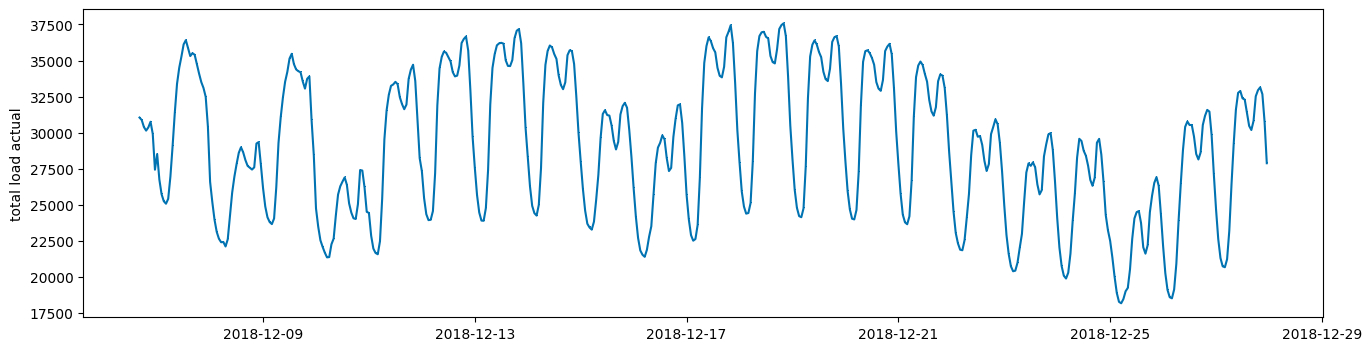

In [8]:
plot_series(y['total load actual'], markers=",")

## Step 4. Univariate Forecasting with a Seasonal Naive Forecaster

For this experiment, we want to create forecasts for our target variable `total load actual` which describes daily energy demand. 

Initially, we'll use a naive method to create baseline forecasts for our data. [Naive forecasting](https://otexts.com/fpp3/simple-methods.html) methods are based on the assumption that the best predictor of a future value is the current value <sup>1</sup>. For our use case of hourly energy demand, we can think of the simplest implementation of naive forecasting to mean that the predicted energy demand for the next hour should be equal to the previous hour's energy demand. In practice, adding a small amount of random variation to naive predictions often improves them. 

We can also improve naive forecasts by taking advantage of seasonal patterns observed in our data. In the case of our hourly energy demand data, we can see patterns in the time series within a one day period, indicating a seasonal periodicity of a day. Instead of forecasting the next hour's energy demand to be similar to the previous hour's energy demand, we can forecast the next hour's energy demand to be similar to the energy demand for that same hour on the previous day.

To do this, we'll first specify the forecaster to use, in this case the [`NaiveForecaster`](https://www.sktime.net/en/stable/api_reference/auto_generated/sktime.forecasting.naive.NaiveForecaster.html). The `NaiveForecaster` works by generating a 'last window' of historical data on which to base the forecasts. In the case of our hourly energy demand data with observed intra-day seasonality, our window length will consist of the previous 24-hour period for this 'last window'.

We have to specify a `strategy` to the forecaster, describing how to utilize the data in the 'last window'. We set the strategy as `last`, meaning that the forecaster should take into account the last value in the window, as opposed to taking a mean over all the data in the window. In combination, we set the seasonal periodicity or `sp` to `24` to account for the intra-day seasonality that we have observed. Together, these two settings implement our seasonal naive strategy described above, where the value of energy demand at a given hour is predicted using the energy demand at that hour on the previous day.

Once the forecaster is initialized with the parameters as described above, we call the `fit` method on the `forecaster`, passing our data `y['total load actual]` which contains the rows of historical data that we pass to our model for input. In this case, we are making predictions based on only one column of input data, so our forecast is a univariate forecast.

Next, we call the `predict` method to create the forecasts, passing a forecasting horizon `fh` equal to our `future_context` to generate the correct number of forecasted data points into the future.



In [9]:
# specify the forecasting algorithm including strategy and seasonal periodicity
forecaster = NaiveForecaster(strategy="last", sp=24)

# specify the forecasting horizon
fh = np.arange(1, future_context + 1)  # we want to predict the next x hours

# fit the forecaster
forecaster.fit(y['total load actual'])

# make predictions using the forecaster
y_pred = forecaster.predict(fh)

For an initial evaluation of our model's performance, we'll use a data visualization. Here, we plot the predictions (shown in gold), along with the historical data (shown in blue) for past values. We can also see the green line, our `y_actual` or the ground truth against which to compare our predictions.

The gold line predicts hourly energy demand based on patterns in the historical data. We can observe the forecast pattern of our naive seasonal forecaster here. It looks like it's simply repeated the last 24 hours of the input data across the forecast horizon. 

In evaluating the green line against the gold line, we can see instances of overlap where the model's predictions are accurate. The naive forecaster has gotten very close on some of the data points. 


(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='total load actual'>)

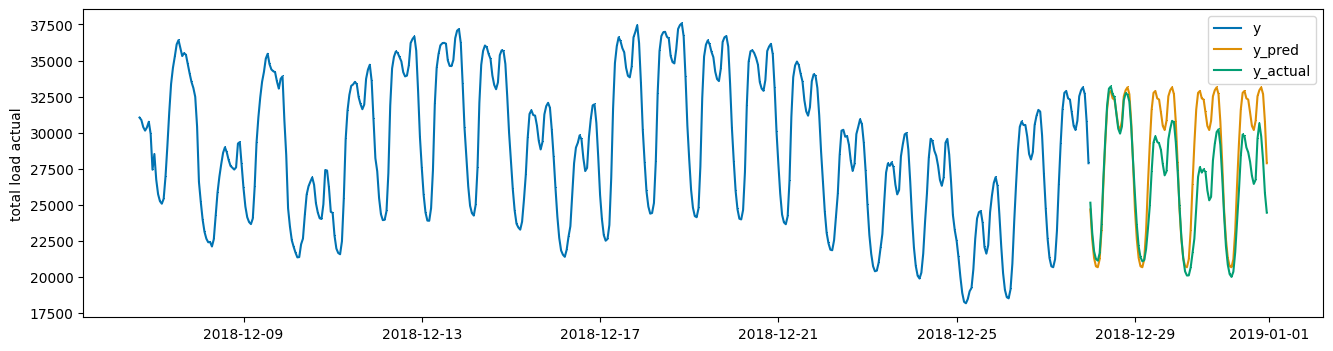

In [10]:
plot_series(y['total load actual'], y_pred, y_actual['total load actual'], labels=["y", "y_pred", "y_actual"], markers=[',', ',', ','])

We can also calculate evaluation metrics to quantify the accuracy of the model. We'll use the [Mean Absolute Percentage Error (MAPE)](https://www.sktime.net/en/stable/api_reference/auto_generated/sktime.performance_metrics.forecasting.mean_absolute_percentage_error.html#sktime.performance_metrics.forecasting.mean_absolute_percentage_error) as our metric. A lower percentage is better and our result, at less than 10%, is a good indication of the performance of the model for this use case. As shown in our example, naive forecasters can often perform surprisingly well. For this reason, they are often used for baseline predictions as a first step before more advanced modeling methods. 

In [11]:
mean_absolute_percentage_error(y_actual['total load actual'], y_pred) * 100

7.991385858936119

## Step 5. Multivariate Forecasting

While our seasonal naive forecaster performed reasonably well on the data, we can likely improve our forecast using a more sophisticated model. Beyond using only one variable for prediction, we can take advantage of the other columns in the dataset to provide additional input for forecasting. In this case, information about weather and the amount of energy generated by various sources might contain signals that affect the target variable `total load actual`.

### Step 5.1 Explore the Data

We shouldn't assume that all of the columns in our dataset are valuable in forecasting our target variable. In forecasting, we only want to provide columns to our model if we know that they show some ailgnment with our target variable. We'll have to explore the data further to decide which variables to include. For initial data exploration, we can look at correlations between our variables. The following correlation plot simply examines the relationship between each of our variables on an x and y axis. It can only examine two variables at once and it doesn't take into account the temporal component (timestamp) of our data, but these correlations can be a useful first step of [exploratory data analysis (EDA)](https://www.ibm.com/think/topics/exploratory-data-analysis).

In [12]:
colors = ["#e5f6ff", "#82cfff", "#3ddbd9", "#be95ff", "#ff7eb6"]

corr = df.corr()

dev_brand_cmap = ListedColormap(colors, "dev_brand")

corr.style.background_gradient(cmap=dev_brand_cmap)

,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind onshore,forecast solar day ahead,forecast wind onshore day ahead,total load forecast,total load actual
generation biomass,1.000000,0.230034,-0.021522,0.433733,0.459588,-0.045055,-0.284648,-0.033352,-0.021065,0.658392,-0.560600,-0.004746,-0.346073,-0.068688,-0.008757,-0.072391,0.085633,0.083438
generation fossil brown coal/lignite,0.230034,1.000000,0.499899,0.768819,0.314885,-0.324024,-0.524707,-0.228906,-0.007578,0.097981,0.104386,0.040033,0.282888,-0.434212,0.041850,-0.436119,0.279087,0.280729
generation fossil gas,-0.021522,0.499899,1.000000,0.541687,0.309545,-0.420747,-0.271495,0.060344,-0.112268,-0.065987,0.334827,0.074464,0.275167,-0.397335,0.079865,-0.397337,0.543760,0.548990
generation fossil hard coal,0.433733,0.768819,0.541687,1.000000,0.440851,-0.406298,-0.497573,-0.157093,-0.023168,0.264624,-0.019593,0.045870,0.170264,-0.441781,0.047012,-0.444420,0.394870,0.396947
generation fossil oil,0.459588,0.314885,0.309545,0.440851,1.000000,-0.330967,-0.106458,0.160700,0.015430,0.374773,-0.115386,0.100213,-0.176109,-0.051755,0.096491,-0.058223,0.498497,0.496173
generation hydro pumped storage consumption,-0.045055,-0.324024,-0.420747,-0.406298,-0.330967,1.000000,0.053197,-0.234451,0.012494,0.021258,-0.267355,-0.214355,-0.188288,0.389139,-0.221756,0.390539,-0.559814,-0.562769
generation hydro run-of-river and poundage,-0.284648,-0.524707,-0.271495,-0.497573,-0.106458,0.053197,1.000000,0.652724,-0.124114,-0.127353,0.053214,0.039655,-0.286303,0.223203,0.045172,0.226447,0.120586,0.118340
generation hydro water reservoir,-0.033352,-0.228906,0.060344,-0.157093,0.160700,-0.234451,0.652724,1.000000,-0.049216,0.065300,-0.065920,0.091686,-0.288154,-0.019419,0.102927,-0.011726,0.476691,0.479253
generation nuclear,-0.021065,-0.007578,-0.112268,-0.023168,0.015430,0.012494,-0.124114,-0.049216,1.000000,0.041723,-0.062053,0.003860,0.087578,0.048472,-0.001003,0.044919,0.090866,0.085803
generation other,0.658392,0.097981,-0.065987,0.264624,0.374773,0.021258,-0.127353,0.065300,0.041723,1.000000,-0.443450,-0.016822,-0.359655,0.047374,-0.019434,0.044602,0.101702,0.100768


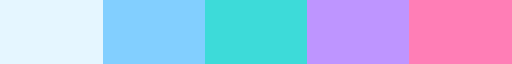

In [13]:
dev_brand_cmap

In interpreting this correlation plot, the colors with the strongest correlations are shown in purple and pink. If we look at the `total load actual` column, we can see which other features in the dataset are strongly correlated with our target column. Based on this data, we can probably assume that the column `total load forecast` contains previously forecasted values for our target columns. Since it's so closely correlated with our target variable and it's an existing forecast, we should exclude this column from our forecasting model. Including it might bias the model, making it good at predicting these exact values but bad at generalizing to other unseen values. It would be a bit like studying for a test by using the answer key for the upcoming test.

Other columns, shown in purple, that exhibit correlations with our target variable include `generation fossil gas`, `generation fossil hard coal`, `generation fossil oil`, `generation hydro water reservoir`, `generation solar` and `forecast solar day ahead`. While this correlation matrix is a good first step in exploring our data, we'll perform more statistical testing before selecting the input columns to our multivariate forecast model. 

### Step 5.2 Split the Data

We'll need to split the data again for our multivariate forecast because our existing data split included only our target variable. Now, we want to include the additional data columns in our training and testing data sets. 

In [14]:
# split the data
y, y_actual = temporal_train_test_split(df, train_size=num_of_rows, test_size=future_context, anchor="end")
y.shape

(512, 18)

### Step 5.3 Test for Stationarity

Some forecasting models have requirements that the time series data exhibit certain properties in order to correctly apply the model. The `NaiveForecaster` that we used in univariate forecasting didn't have many requirements, but the `VAR` model that we'll use in our multivariate forecast requires that the time series be stationary <sup>1</sup>.

A time series is stationary if it doesn't exhibit seasonality or trend. Ideally, a stationary time series should look like white noise, without any overall trend or patterns repeating at stable intervals. We've already observed that our time series demonstrates daily seasonality, so we will likely have to transform the data to fit the requirements of the `VAR` model. 

First, we'll perform a statistical test from `sktime` called [`StationarityADF`](https://www.sktime.net/en/stable/api_reference/auto_generated/sktime.param_est.stationarity.StationarityADF.html#sktime.param_est.stationarity.StationarityADF), an implementation of the Augmented Dickey-Fuller (ADF) Unit Root Test, to check for stationarity. If the test cannot fit a single unit root to the data, then the time series is determined to be stationary. Otherwise, the time series is non-stationary. For our multivariate analysis, we'll test all the columns in the dataset using this method. 

If a column doesn't show stationarity based on the ADF test, we'll apply a transformation called differencing to remove the seasonality in our data.

Differencing works by calculating the difference between points in a time series and using those differences rather than the absolute values of the time series. In the case of our data with daily seasonality, the differencing transformer is set to use a 24-hr lag. 

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='total load actual'>)

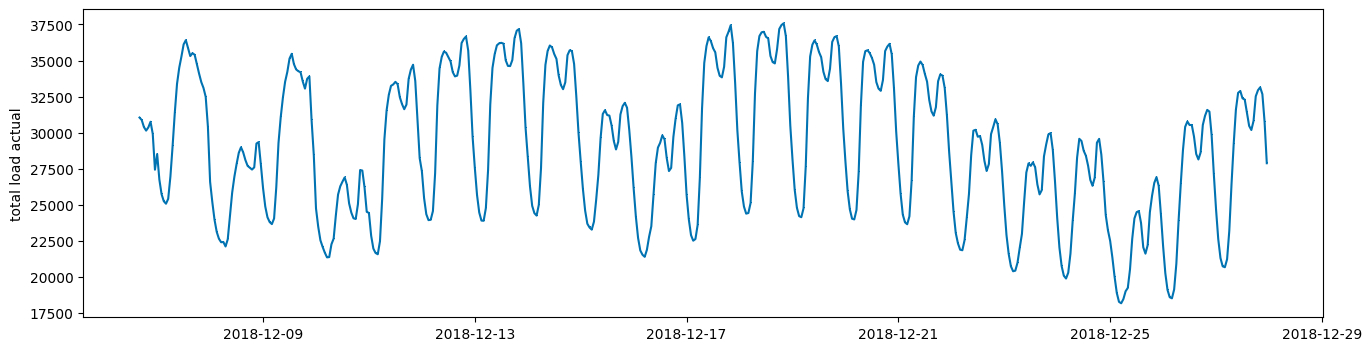

In [15]:
plot_series(y['total load actual'], markers=",")

Above, we can observe the time series with daily seasonality. Below, we'll set up the ADF test for stationarity and the transformer to apply differencing, hopefully making the time series stationary.

In [16]:
# set up the ADF test for stationarity
sty_est = StationarityADF()  

In [17]:
# set up the differencer transformer to correct for stationarity
transformer = Differencer(lags=[1, 24])

In [18]:
# test each feature for stationarity and difference if necessary, save the results in a dict

params_dict = {}

for col in y.columns:
    sty_est.fit(y[col])
    params_dict[col] = sty_est.get_fitted_params()
    if params_dict[col]['stationary'] == False:
        y = y.apply(lambda x : transformer.fit_transform(x) if x.name == col else x)
        sty_est.fit(y[col])
        params_dict[col] = sty_est.get_fitted_params()

Following testing and transformation, we can observe that all of the features in the dataset now exhibit stationarity. We can also visualize the differenced time series for our target variable. This version of the data looks somewhat like white noise, with no periodic patterns or obvious trends.

In [19]:
for key in params_dict.keys():
    print(key + ', ' + 'stationary: ' +  str(params_dict[key]['stationary']))

generation biomass, stationary: True
generation fossil brown coal/lignite, stationary: True
generation fossil gas, stationary: True
generation fossil hard coal, stationary: True
generation fossil oil, stationary: True
generation hydro pumped storage consumption, stationary: True
generation hydro run-of-river and poundage, stationary: True
generation hydro water reservoir, stationary: True
generation nuclear, stationary: True
generation other, stationary: True
generation other renewable, stationary: True
generation solar, stationary: True
generation waste, stationary: True
generation wind onshore, stationary: True
forecast solar day ahead, stationary: True
forecast wind onshore day ahead, stationary: True
total load forecast, stationary: True
total load actual, stationary: True


(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='total load actual'>)

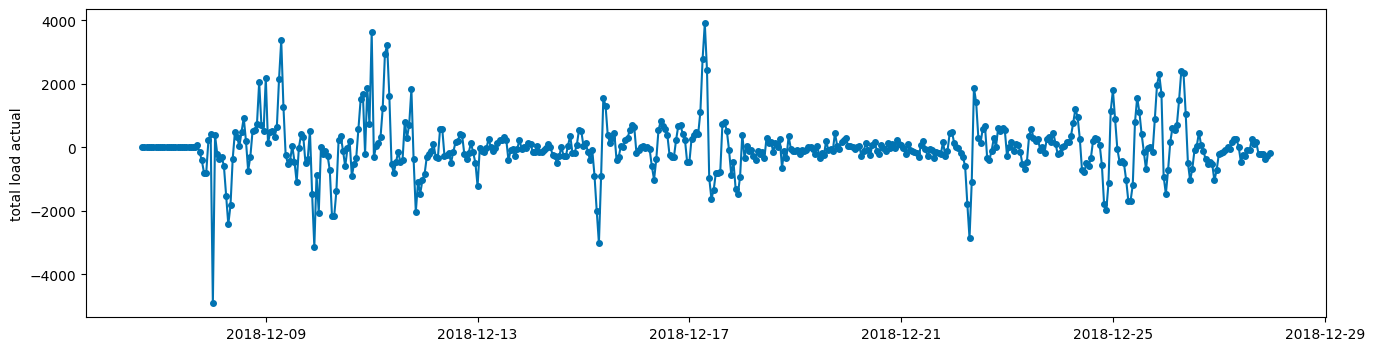

In [20]:
plot_series(y['total load actual'])

### Step 5.4 Feature Selection

Given all the columns in our dataset, we need a way to select the columns that will provide the most predictive input to our model. We'll use a procedure called Granger causality testing to examine the features in our data and to measure the strength of their relationship to our target variable. 

While we should be cautious of promises to discern causality between variables, [Granger causality](https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.grangercausalitytests.html#statsmodels.tsa.stattools.grangercausalitytests) examines whether one time series is predictive of another, given a stated time lag. We will test all of our features (except `total load forecast` as discussed earlier) against our target variable `total load actual` to determine which variables to include as input to our model. We'll fit a lag of up to 24 hours during the testing.

For results with a p value < .05, we can accept that the given feature in our time series is predictive of our target variable.



In [21]:
# use a Granger causality test to determine which features are predictive of the target variable

import warnings
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)

    selected_features = []
    for col in y.columns[:-2]:
        if params_dict[col]['used_lag'] > 0:
            res_dict = grangercausalitytests(y[[col, 'total load actual']], 24, verbose=False)
            p_val = res_dict[1][0]['ssr_ftest'][1]
            if p_val < .05:
               selected_features.append(col)
    print(selected_features)

['generation fossil oil', 'generation hydro water reservoir']


After statistical testing, we've selected 2 features from the dataset to pass to our model `generation fossil oil` and `generation hydro water reservoir`. These features were correlated with `total load actual` in our initial correlation testing, but Granger causation analysis also allowed us to explore the relationship between these variables while considering the temporal element. Using this method, we were able to further narrow the list of variables from correlation testing and ultimately select these variables as input to our multivariate forecasting model.

In [22]:
# subset the dataframe by the selected features, plus target variable
selected_features.append('total load actual')
y_subset = pd.DataFrame(y[selected_features], index=y.index)
y_subset.tail()

,generation fossil oil,generation hydro water reservoir,total load actual
2018-12-27 19:00,315.0,6573.0,-215.0
2018-12-27 20:00,308.0,4822.0,-208.0
2018-12-27 21:00,308.0,4186.0,-355.0
2018-12-27 22:00,307.0,4032.0,-269.0
2018-12-27 23:00,306.0,4067.0,-167.0


### Step 5.5 Forecasting

After testing several models on this data set, we're settling on a [`VAR`](https://www.sktime.net/en/stable/api_reference/auto_generated/sktime.forecasting.var.VAR.html#id4) or vector autoregression model for multivariate forecasting. We've chosen this model because it is fairly fast to fit the model to our data and it performs better than our univariate forecasting model as well at several other multivariate forecasting models that we tried. 

A vector autoregression model can represent the interactions between different time series and forecast values for any of the examined time series.<sup>1</sup> While the model can produce accurate forecasts, one of its shortcomings is that it doesn't provide a hypothesis for why the system of time series behaves the way that it does. For our purposes however, the VAR model is sufficient. 

As mentioned previously, one of the requirements for this model is that the time series be stationary, but we've already met this requirement by testing and transforming the data in Step 5.3.

In order to create our forecasts, we first create the `forecaster`, specifying the `ic` or information criterion to optimize for. We'll use the `bic` or Bayesian Information Criterion which is often used with VAR models. <sup>1</sup>

Next, we pass our data `y_subset` to the `fit` method along with the same forecast horizon that we used for our univariate forecasting model. Finally, we call the `predict` method to create our forecasts.



In [23]:
forecaster = VAR(ic='bic')
forecaster.fit(y_subset, fh= np.arange(1,future_context + 1))

y_pred = forecaster.predict()

In [24]:
y_pred.head()

,generation fossil oil,generation hydro water reservoir,total load actual
2018-12-28 00:00,305.240528,3856.877506,-168.430899
2018-12-28 01:00,304.012003,3552.347326,-195.883269
2018-12-28 02:00,302.386861,3247.524680,-203.160897
2018-12-28 03:00,300.550314,2994.660889,-185.454905
2018-12-28 04:00,298.680844,2814.358351,-153.724393


### Step 5.6 Evaluation

Let's evaluate our model results using the same evaluation metrics as our univariate modeling. In order to compare against our ground truth data, we'll first remove the differencing transformation that was applied. 


In [25]:
# remove differencing from predictions and columns

y_pred_dediff = transformer.inverse_transform(y_pred['total load actual'])

y = y.apply(lambda x : transformer.inverse_transform(x))

Then, we'll plot the predictions, shown in gold, along with the historical data (shown in blue) against the ground truth data (shown in green). You might notice how the forecast intially tracks close to the actual data at the start of the forecast horizon, but drifts further from the actual values towards the end of the forecast horizon. This behavior has been observed in multivariate forecasts. They are often very good in the near short-term, but less reliable over time.<sup>2</sup>



(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='total load actual'>)

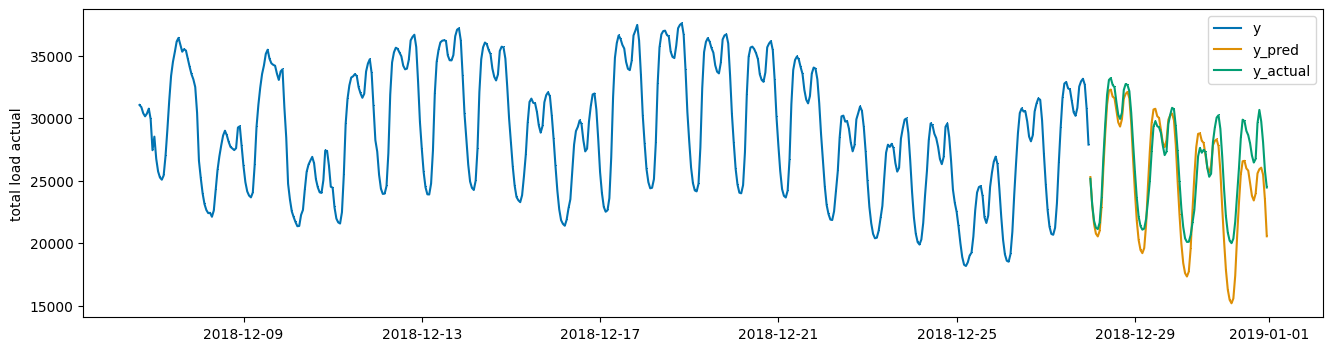

In [26]:
plot_series(y['total load actual'], y_pred_dediff, y_actual['total load actual'], labels=["y", "y_pred", "y_actual"], markers=[',',',',','])

In examining our MAPE for this forecast, at ~7.20 it's slightly better than ~7.99 for our univariate forecast.

In [27]:
mean_absolute_percentage_error(y_actual['total load actual'], y_pred_dediff) * 100

7.195281205188215

The plot along with our calculated MAPE demonstrate that our multivariate forecast is more accurate than our univariate forecast. Given these results, it seems likely that the selected columns passed as input to our forecaster have improved the forecast.

## Summary

In this tutorial, we leveraged the capabilities of `sktime` to perform univariate and multivariate forecasting predicting energy demand. In our univariate forecast, we predicted energy demand using a Naive Seasonal forecaster. For multivariate forecasting, we used the additional exogenous variables in our dataset such as weather and other energy sector forecasts to make a prediction using a VAR forecaster. In general our multivariate forecast performed better than the univariate forecast. 
1. Hyndman, R.J., & Athanasopoulos, G. (2021) Forecasting: principles and practice, 3rd edition, OTexts: Melbourne, Australia. OTexts.com/fpp3. Accessed on April 9, 2025.
2. S. Salehi, M. Kavgic, H. Bonakdari, L. Begnoche, Comparative study of univariate and multivariate strategy for short-term forecasting of heat demand density: Exploring single and hybrid deep learning models, Energy and AI, Volume 16, 2024, 100343, ISSN 2666-5468, https://doi.org/10.1016/j.egyai.2024.100343.
